In [424]:
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

trainLoan = pd.read_csv('Documents/trainLoadPred.csv')
testLoan = pd.read_csv('Documents/testLoanPred.csv')


In [333]:
trainLoan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [313]:
#summarizing the data to understand how to handle missing values 
trainLoan.describe(include='all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614,601,611,599,614,582,614.000000,614.000000,592.000000,600.00000,564.000000,614,614
unique,614,2,2,4,2,2,NaN,NaN,NaN,NaN,NaN,3,2
top,LP002978,Male,Yes,0,Graduate,No,NaN,NaN,NaN,NaN,NaN,Semiurban,Y
freq,1,489,398,345,480,500,NaN,NaN,NaN,NaN,NaN,233,422
mean,NaN,NaN,NaN,NaN,NaN,NaN,5403.459283,1621.245798,146.412162,342.00000,0.842199,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,6109.041673,2926.248369,85.587325,65.12041,0.364878,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.000000,9.000000,12.00000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2877.500000,0.000000,100.000000,360.00000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3812.500000,1188.500000,128.000000,360.00000,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5795.000000,2297.250000,168.000000,360.00000,1.000000,NaN,NaN


In [411]:
def convertCategoricalColumnsIntoNumbers(df):
            
    le = preprocessing.LabelEncoder()
    # Converting string labels into numbers and fill in missing values.
    for value in ['Gender', 'Married', 'Self_Employed', 'Education', 'Loan_Status', 'Dependents']:
        df[value].fillna(df.describe(include='all')[value][2],inplace=True)
        df[value]=le.fit_transform(df[value])
    
    for value in [ 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History','Loan_Amount_Term','Property_Area']:
        df[value].fillna(df.describe(include='all')[value][4],inplace=True)
        df[value]=le.fit_transform(df[value])


In [412]:
#Feature Scaling 
def featureScaling(df):
    scaler = preprocessing.StandardScaler()
    scaled_df = scaler.fit_transform(df[['CoapplicantIncome','ApplicantIncome', 'LoanAmount']])
    scaled_df = pd.DataFrame(scaled_df, columns=['CoapplicantIncome', 'ApplicantIncome', 'LoanAmount'])
    df['CoapplicantIncome'] = scaled_df['CoapplicantIncome']
    df['ApplicantIncome'] = scaled_df['ApplicantIncome']
    df['LoanAmount'] = scaled_df['LoanAmount']
    

In [425]:
convertCategoricalColumnsIntoNumbers(trainLoan)

In [369]:
#Feature Importance - Do we need all the features for our analysis or can we drop some features 
#Irrelevant or partially relevant features can negatively impact model performance.So here we try to score the features 
#Below is an example of a chi-squared test to pick the top 5 features - works only on non-negative features  

X_train = trainLoan.drop(columns=['Loan_ID', 'Loan_Status'])
y_train =  trainLoan['Loan_Status']
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 10 best features

               Specs      Score
9     Credit_History  51.987925
7         LoanAmount  36.027377
6  CoapplicantIncome   4.068612
3          Education   3.540502
1            Married   1.782425


C:\Users\shruti\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.02766538 0.02359291 0.06198535 0.01961685 0.02443548 0.16860508
 0.11101137 0.1689415  0.05304103 0.27505202 0.06605302]


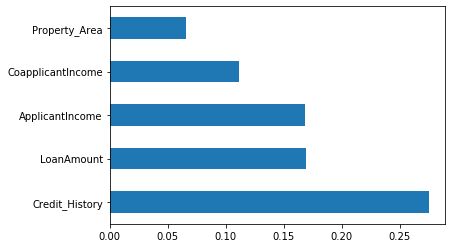

In [370]:
#Here we try to compute the important features using tree based classifiers and as expected Credit_History is the most important feature 
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

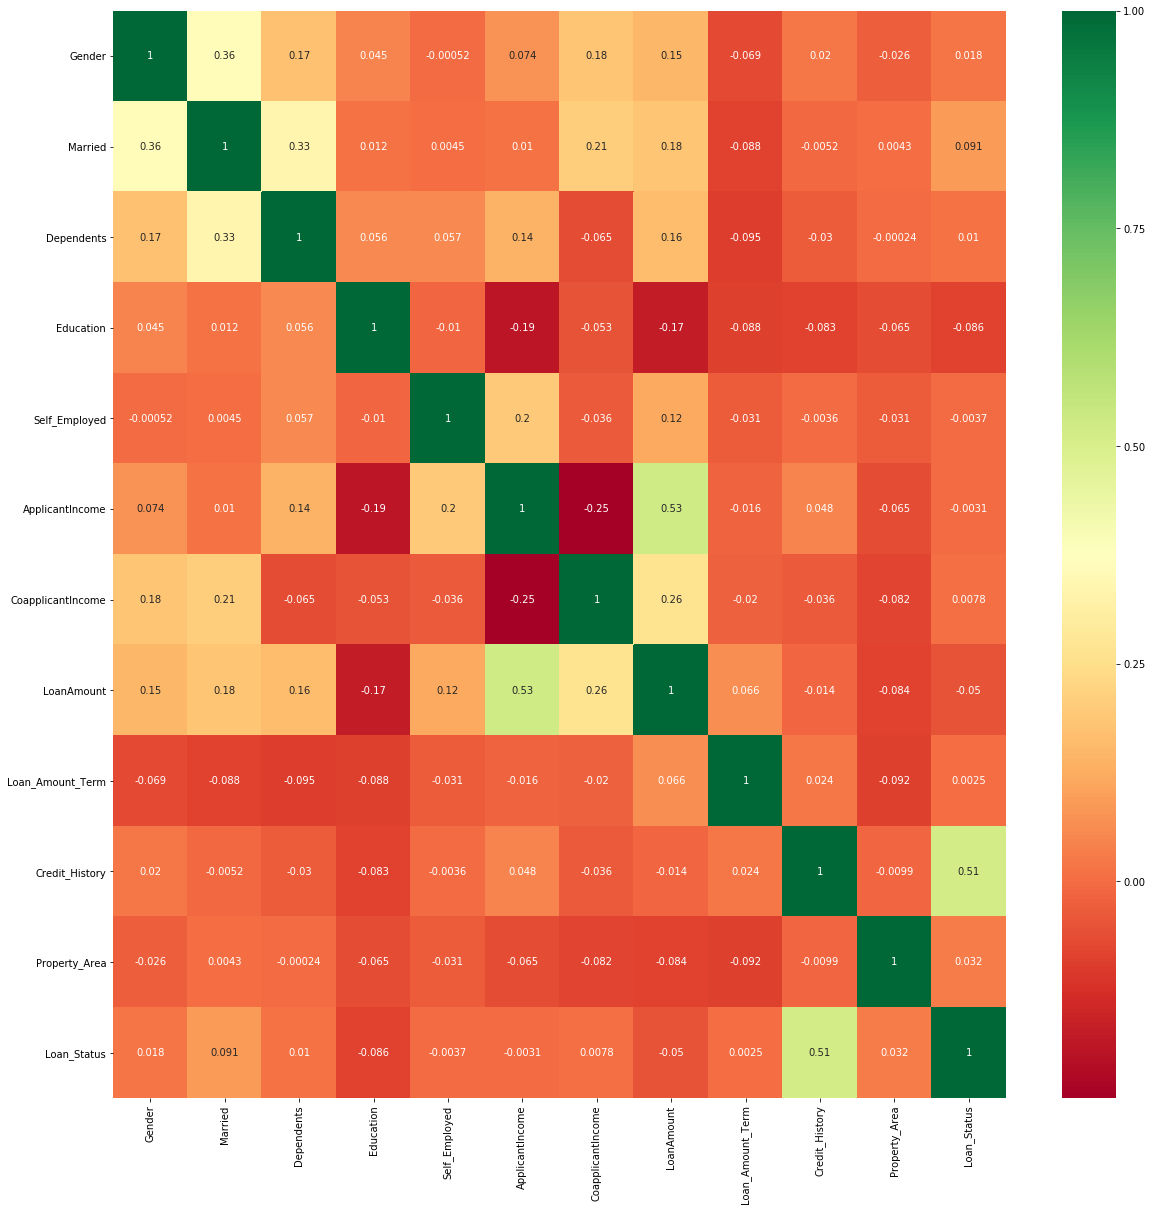

In [372]:
#Correlation of the features and which feature is most correlated with the target variable
#Again we see that Credit History is highly correlated, followed by Married, Education, LoanAmount and Property Area

data = pd.concat([X_train,y_train], axis=1)
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
#Based on the above it looks like all the 3 tests - chi squared, tree based classifier and correlation matrix pick almost the
#same features. We will run the classification algorithms with all the features as well as a smaller (high score) feature set
#This will helpus understand if feature enginnering improves our model 

In [426]:
featureScaling(trainLoan)

In [427]:
#Split dataset into train and test, roughly 80-20
testData = trainLoan.loc[len(trainLoan)-150 : len(trainLoan)-1,:]
trainLoan = trainLoan.loc[0:len(trainLoan)-151 ,:]

In [379]:
#Check if there are any NANs - classifier algorithms dont run with NANs

X_train.isna().any()

Gender               False
Married              False
Dependents           False
Education            False
Self_Employed        False
ApplicantIncome      False
CoapplicantIncome    False
LoanAmount           False
Loan_Amount_Term     False
Credit_History       False
Property_Area        False
dtype: bool

In [428]:
#Naive Bayes Classification Technique
def NaiveBayesClassifier(xtrain, ytrain, xtest):
    model = GaussianNB()
    
    model.fit(xtrain, ytrain);
    #Run the naive bayes on test data
    testData['Loan_Status_Predicted_NB'] = model.predict(xtest)
    #Generate the confusion matrix
    print(confusion_matrix(testData['Loan_Status'] ,testData['Loan_Status_Predicted_NB']))
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(testData['Loan_Status'] , testData['Loan_Status_Predicted_NB']))
    

In [431]:
#Logistic Regression Technique
def LogisticRegression(xtrain, ytrain, xtest):
    logistic = linear_model.LogisticRegression()
    logistic.fit(xtrain, ytrain)
    testData['Loan_Status_Predicted_Logistic'] = logistic.predict(xtest)
    #Generate the confusion matrix
    print(confusion_matrix(testData['Loan_Status'] ,testData['Loan_Status_Predicted_Logistic']))
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(testData['Loan_Status'] , testData['Loan_Status_Predicted_Logistic'])) 

In [433]:
#K Nearest Neighbors Technique
def KNNClassifier(xtrain, ytrain, xtest):
    #K Nearest Neighbor Classification 
    model = KNeighborsClassifier(n_neighbors=14)

    # Train the model using the training sets
    model.fit(xtrain,ytrain)

    #Predict Output
    testData['Loan_Status_Predicted_KNN'] = model.predict(xtest)
    #Generate the confusion matrix
    print(confusion_matrix(testData['Loan_Status'] ,testData['Loan_Status_Predicted_KNN']))
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(testData['Loan_Status'] , testData['Loan_Status_Predicted_KNN']))

In [429]:
#Naive Bayes Classifier on the training set with all the features
X_train = trainLoan.drop(['Loan_ID', 'Loan_Status'], axis=1)
y_train = trainLoan[['Loan_Status']]
X_test = testData.drop(['Loan_ID', 'Loan_Status'], axis=1)
NaiveBayesClassifier(X_train, y_train, X_test)


[[27 21]
 [11 91]]
Accuracy: 0.7866666666666666


C:\Users\shruti\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [432]:
#Logistic Regression Classifier on the training set with all the features
LogisticRegression(X_train, y_train, X_test)

[[25 23]
 [ 9 93]]
Accuracy: 0.7866666666666666


C:\Users\shruti\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\shruti\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [434]:
#KNN Classifier on the training set with all the features
KNNClassifier(X_train, y_train, X_test)

[[ 22  26]
 [  2 100]]
Accuracy: 0.8133333333333334


C:\Users\shruti\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [436]:
#Use only the features with high score/hogh correlation with the response variable.
#Once the 5 features are chosen, run the same 3 classification techniques as described above - 1) Naive Bayes 2) Logistic Regression
#and 3) KNN Classification Technique
X_train = trainLoan[['LoanAmount', 'CoapplicantIncome', 'Education', 'Credit_History', 'Married']]
y_train = trainLoan['Loan_Status']
X_test = testData[['LoanAmount', 'CoapplicantIncome', 'Education', 'Credit_History', 'Married']]
NaiveBayesClassifier(X_train, y_train, X_test)

[[27 21]
 [10 92]]
Accuracy: 0.7933333333333333


In [437]:
LogisticRegression(X_train, y_train, X_test)

[[26 22]
 [ 6 96]]
Accuracy: 0.8133333333333334


C:\Users\shruti\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [438]:
KNNClassifier(X_train, y_train, X_test)

[[26 22]
 [ 5 97]]
Accuracy: 0.82
